# 75.06 / 95.58 Organización de Datos
# Trabajo Práctico 1

### Grupo 30: Datatouille

- 101055 - Bojman, Camila
- 100029 - del Mazo, Federico
- 100687 - Hortas, Cecilia
- 97649 - Souto, Rodrigo

> https://github.com/fdelmazo/7506-datos

In [1]:
# Set-Up inicial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify # https://github.com/laserson/squarify ( pip install squarify )
import geopandas as gpd # http://geopandas.org/install.html ( conda install -c conda-forge geopandas o pip install geopandas )
from shapely.geometry import Point
from wordcloud import WordCloud # pip install wordcloud
from time import strptime
import calendar

df = pd.read_csv('events.csv', low_memory=False, index_col='timestamp')

In [2]:
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (15,5)

## Información general del dataset

In [3]:
with pd.option_context('display.max_column',0):
    display(df.sample(n=5))

,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
timestamp,,,,,,,,,,,,,,,,,,,,,,
2018-04-27 18:09:24,viewed product,351d2032,NaN,6411.0,Samsung Galaxy J7,Excelente,16GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-29 13:15:05,ad campaign hit,5c54c958,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zanox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-18 01:16:44,viewed product,3eb8d8c4,NaN,2836.0,iPhone 6,Bom,128GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04 15:52:58,viewed product,4bd64f72,NaN,2830.0,iPhone 6,Bom,16GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07 18:50:13,viewed product,207834d9,NaN,10351.0,Motorola Moto G4 Plus,Muito Bom,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print('{} atributos y {} registros en el dataframe.\n'.format(df.shape[1],df.shape[0]))
print('Primer registro: {} \nÚltimo registro: {}.'.format(df.index.min(),df.index.max()))

22 atributos y 1011288 registros en el dataframe.

Primer registro: 2018-01-01 07:32:26 
Último registro: 2018-06-15 23:59:31.


In [5]:
bytes_used = df.memory_usage().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1011288 entries, 2018-05-31 23:38:05 to 2018-06-04 23:18:10
Data columns (total 22 columns):
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                      87378 non-null object
cou

In [6]:
with pd.option_context('display.max_colwidth',-1):
    display(pd.read_csv('columns-desc.csv',index_col='column'))

,description
column,
timestamp,Fecha y hora cuando ocurrió el evento.
event,Tipo de evento.
person,Identificador de cliente que realizó el evento.
url,Url visitada por el usuario.
sku,Identificador de producto relacionado al evento.
model,Nombre descriptivo del producto incluyendo marca y modelo.
condition,Condición de venta del producto.
storage,Cantidad de almacenamiento del producto.
color,Color del producto.


In [7]:
df.describe().T

,count,unique,top,freq
event,1011288,11,viewed product,528931
person,1011288,27624,71492f2b,2771
url,82756,227,/,28323
sku,563838,3574,2830.0,4282
model,564284,202,iPhone 6,50916
condition,563836,5,Bom,243014
storage,563836,8,16GB,190833
color,563836,63,Preto,132960
skus,221699,35310,"2820,6706,6720,2750,6649,7251,6663,12604,7224,...",594
search_term,48967,5851,Iphone,1207


In [8]:
df.isnull().sum()

event                             0
person                            0
url                          928532
sku                          447450
model                        447004
condition                    447452
storage                      447452
color                        447452
skus                         789589
search_term                  962321
staticpage                  1007690
campaign_source              928492
search_engine                960331
channel                      923910
new_vs_returning             923910
city                         923910
region                       923910
country                      923910
device_type                  923910
screen_resolution            923910
operating_system_version     923910
browser_version              923910
dtype: int64

In [9]:
df.dtypes

event                       object
person                      object
url                         object
sku                         object
model                       object
condition                   object
storage                     object
color                       object
skus                        object
search_term                 object
staticpage                  object
campaign_source             object
search_engine               object
channel                     object
new_vs_returning            object
city                        object
region                      object
country                     object
device_type                 object
screen_resolution           object
operating_system_version    object
browser_version             object
dtype: object

---
#### Pasado el vistazo general a los datos, se pueden transformar datos en sus tipos correspondientes para mejor manejo de estos y para ahorro de memoria

In [10]:
# Los atributos con pocos valores posibles se pasan a variables categoricas para ahorrar memoria
df['event'] = df['event'].astype('category')
df['condition'] = df['condition'].astype('category')
df['storage'] = df['storage'].astype('category')
df['search_engine'] = df['search_engine'].astype('category')
df['channel'] = df['channel'].astype('category')
df['device_type'] = df['device_type'].astype('category')

# El tiempo es mejor manejarlo como tal
df.index = pd.to_datetime(df.index)

# Teniendo solamente dos valores posibles para el tipo de usuario, y priorizando los nuevos, se transforma a una variable booleana
df['new_user'] = df['new_vs_returning'].map(lambda x: True if x == 'New' else False)
df['new_user'] = df['new_user'].astype('bool')

In [11]:
# Chequeo
df.info()

ahorro = (bytes_used - df.memory_usage().sum()) /1000000
print("Memoria ahorrada: {:.4f}MB".format(ahorro))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1011288 entries, 2018-05-31 23:38:05 to 2018-06-04 23:18:10
Data columns (total 23 columns):
event                       1011288 non-null category
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null category
storage                     563836 non-null category
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null category
channel                     87378 non-null category
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                      87378 n

---
## Información de eventos

In [12]:
event = df['event']
event.describe()

count            1011288
unique                11
top       viewed product
freq              528931
Name: event, dtype: object

In [13]:
with pd.option_context('display.max_colwidth',0):
    display(pd.read_csv('events-desc.csv',index_col='event'))

,description
event,
viewed product,El usuario visita una página de producto.
brand listing,El usuario visita un listado específico de una marca viendo un conjunto de productos.
visited site,El usuario ingresa al sitio a una determinada url.
ad campaign hit,El usuario ingresa al sitio mediante una campana de marketing online.
generic listing,El usuario visita la homepage.
searched products,El usuario realiza una búsqueda de productos en la interfaz de búsqueda del site.
search engine hit,El usuario ingresa al sitio mediante un motor de búsqueda web.
checkout,El usuario ingresa al checkout de compra de un producto.
staticpage,El usuario visita una página


Text(0.5,1,'Cantidad de visitas segun evento')

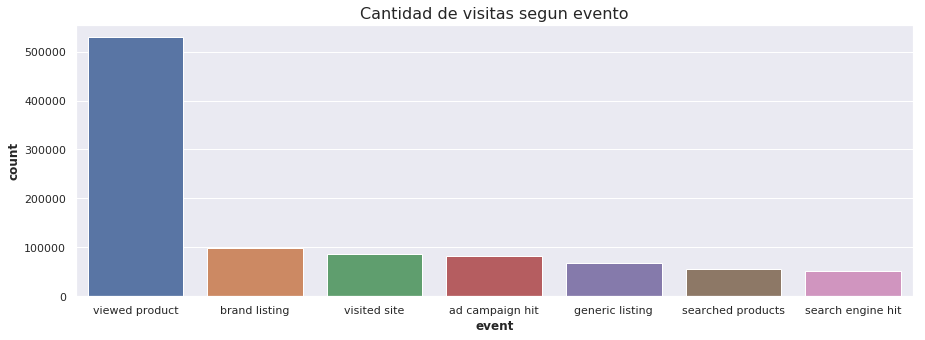

In [14]:
#data = event.value_counts().head(7)
#ax = sns.barplot(x=data.index,y=data)
#ax.set(xlabel='Count',ylabel='Evento')

# Mismo grafico, de otra forma (tarda más tiempo (escribir %%time al comienzo de la celda))
orden = event.value_counts().head(7).index
visu = sns.countplot(x='event',data=df,order=orden)
visu.axes.set_title('Cantidad de visitas segun evento')

---
## Información geográfica

Text(0.5,1,'Países con más visitas')

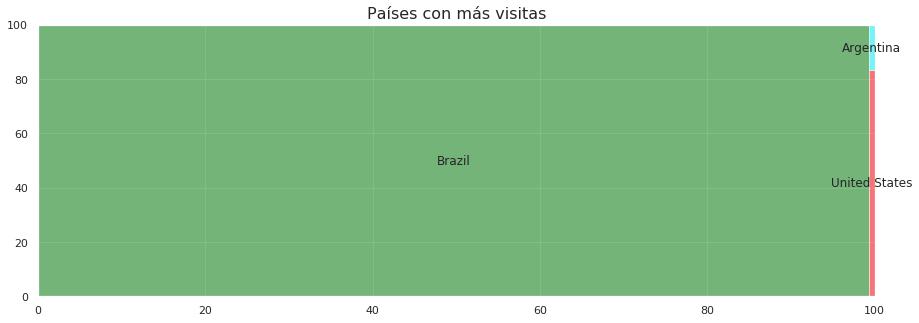

In [15]:
countries = df['country'].value_counts()
countries = countries.drop('Unknown')
data = countries.head(3)

visu = squarify.plot(data, label=data.index, alpha=.5, color=['green','red','cyan'])
visu.axes.set_title('Países con más visitas')

Text(0.5,1,'Países con más visitas, exceptuando Brazil')

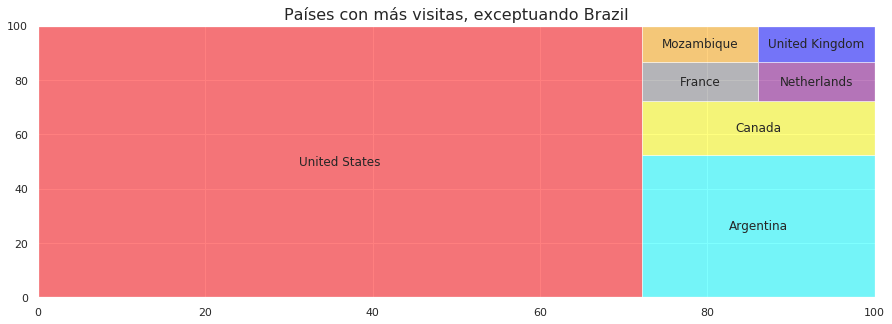

In [16]:
# Siempre supimos (asumimos) que Brazil sería el país con mayor tráfico. 
# Este dato no nos deja ver la proporción del resto de los países
countries = df['country'].value_counts()
countries = countries.drop('Unknown')
countries = countries.drop('Brazil')
data = countries.head(7)

visu = squarify.plot(data, label=data.index, alpha=.5, color=['red','cyan','yellow','grey','purple','orange','blue'])
visu.axes.set_title('Países con más visitas, exceptuando Brazil')

### Sacando las longitudes y latitudes de distintas ciudades del mundo, podemos ver que zonas de los 4 países con más trafico son las que más visitas tienen. 

Con ayuda del módulo geopandas, podemos plotear directamente sobre un mapa
Las bases de datos adicionales fueron sacadas de http://www.geonames.org/

In [17]:
BR = pd.read_csv('BR.csv', low_memory=False, sep='\t')
BR = BR[['name','latitude','longitude']]

# Para que geopandas pueda leer bien las latitudes y longitudes, deben ser pasadas al tipo Point
BR['coordinates'] = list(zip(BR['longitude'],BR['latitude']))
BR['coordinates'] = BR['coordinates'].apply(Point)
BR.head()

,name,latitude,longitude,coordinates
0,Tawaribar Rapids,2.66667,-59.96667,POINT (-59.96666999999999 2.66667)
1,Machpawa Falls,2.90000,-59.95000,POINT (-59.95 2.9)
2,Kulutuik Fall,5.08333,-59.96667,POINT (-59.96666999999999 5.08333)
3,Kukuipawa Falls,2.82548,-59.95024,POINT (-59.95024 2.82548)
4,Kenukawai Mountain,1.46667,-58.43333,POINT (-58.43333000000001 1.46667)


Text(0.5,1,'Ciudades de Brazil con más visitas')

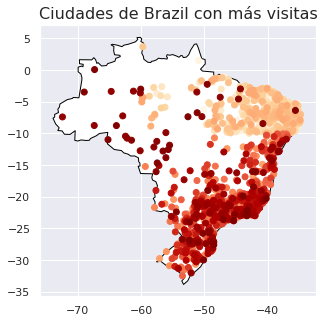

In [18]:
# Se debe hacer un join de los datos que se tienen (nombre de ciudad, cantidad de eventos) y los datos de geonames (nombre de ciudad, punto en el mapa), y esto plotearlo sobre los datos de geopandas (nombre de pais, punto en el mapa mundial)

# Se preparan los datos para el join (inner join de nombre de ciudad (columna name))
ciudades_brazil = df.loc[(df['country'] == 'Brazil')]
data = ciudades_brazil['city'].value_counts()
data = data.drop('Unknown')
data = data.to_frame()
data.reset_index(inplace=True)
data = data.rename(columns={'index':'name','city':'count'})

# Se pasa de un dataframe normal de pandas a uno de geopandas
BRA = gpd.GeoDataFrame(BR, geometry='coordinates')

# Se hace el join (en geopandas: merge) de ambos sets. Siendo que geonames daba mucha más información de la necesaria, duplicando valores por ciudades, se borran los duplicados
data = BRA.merge(data, on='name')
data = data.drop_duplicates('name')

# Se prepara el 'fondo' del gráfico, siendo este nomás el país. Para esto se usan los datos por defecto de geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.name=='Brazil'].plot(color='white',edgecolor='black')

visu = data.plot(ax=ax,cmap='OrRd')
visu.axes.set_title('Ciudades de Brazil con más visitas')

In [19]:
ciudades_argentina = df.loc[(df['country'] == 'Argentina')]
data = ciudades_argentina['city'].value_counts()
data

# Viendo que la mayoría de los eventos de Argentina vienen de Buenos Aires, hacer el gráfico sobre el mapa sería trivial

Buenos Aires       76
Unknown             8
Córdoba             2
Lanus               1
Podesta             1
Isidro Casanova     1
Ramos Mejia         1
Mendoza             1
Lomas de Zamora     1
Rosario             1
Neuquén             1
Name: city, dtype: int64

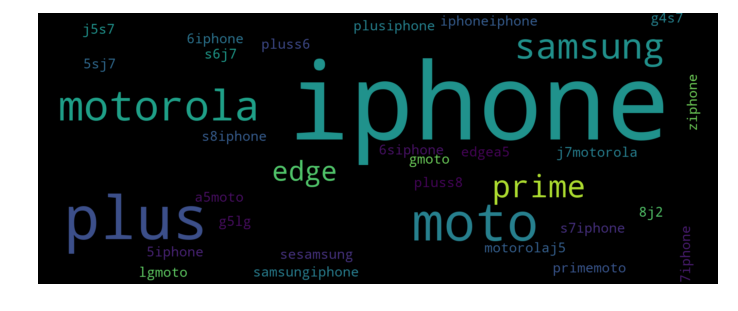

In [20]:
st = df['search_term'].dropna()
st = st.apply(lambda x: x.lower())
st = st.value_counts().to_frame()
st = st.loc[(st['search_term'] >= 300)]

text = ''
for w,q in zip(st.index,st['search_term']):
    text += ' '.join([w for x in range(q)])

text = ' '.join([s for s in text.split() if len(s)>2])    

wordcloud = WordCloud(width=2000, height=800, margin=0,collocations=False).generate(text)
 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Text(111.5,0.5,'Mes')

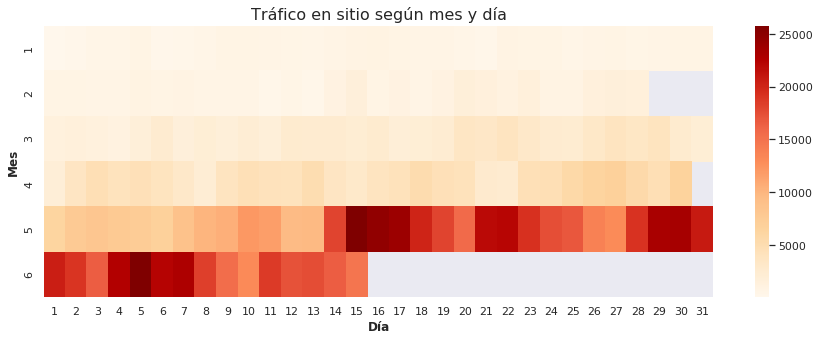

In [21]:
df['month'] = df.index.month
df['day'] = df.index.day
for_heatmap = df.pivot_table(index='month',columns='day', values='event', aggfunc='count')
for_heatmap
g = sns.heatmap(for_heatmap,  cmap="OrRd")
g.set_title("Tráfico en sitio según mes y día")
g.set_xlabel("Día")
g.set_ylabel("Mes")

Text(111.5,0.5,'Mes')

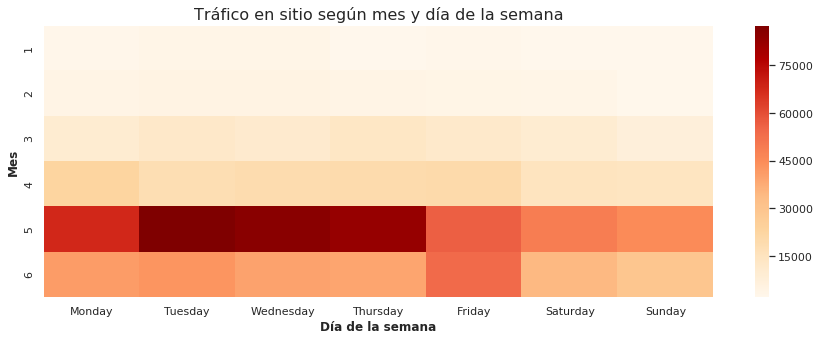

In [22]:
df['month'] = df.index.month
df['week_day'] = df.index.weekday

for_heatmap = df.pivot_table(index='month',columns='week_day', values='event', aggfunc='count')
for_heatmap.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

g = sns.heatmap(for_heatmap,  cmap="OrRd")
g.set_title("Tráfico en sitio según mes y día de la semana")
g.set_xlabel("Día de la semana")
g.set_ylabel("Mes")

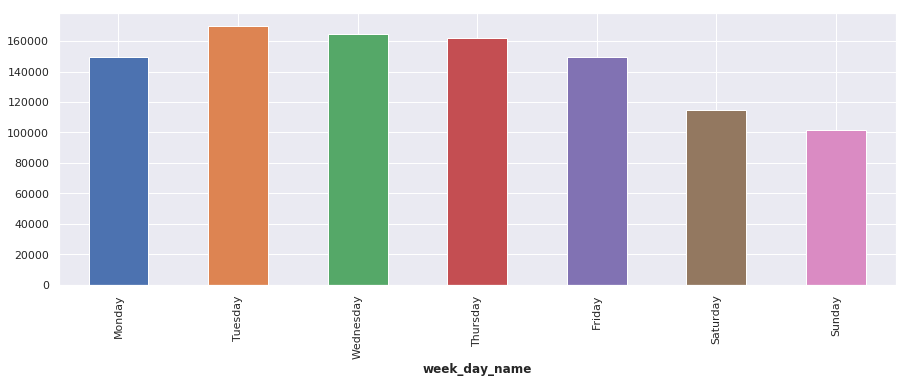

In [23]:
df['week_day_name'] = df.index.weekday_name
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df.groupby('week_day_name').count()
weekday_counts = weekday_counts.loc[weekday_names]
weekday_counts['event'].plot(kind='bar') #Probando, después se tunea

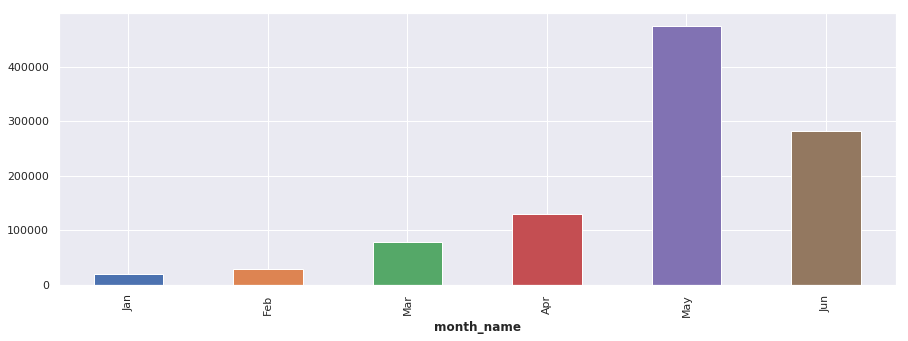

In [24]:
df['month_name'] = df['month'].apply(lambda x: calendar.month_abbr[x])
month_name= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
month_counts = df.groupby('month_name').count()
month_counts
month_counts = month_counts.loc[month_name]
month_counts['event'].plot(kind='bar') #Probando, después se tunea

---
## Conclusiones (insights)

- Intro de trocafone
- Info general del dataset
- Columna por columna graficos interesnates
    - Pregunta
    - Grafico
    - Respuesta / Analisis
- Insights generales

Buenos robos:
- https://jilt.com/blog/ecommerce-metrics/
- https://python-graph-gallery.com/
- https://github.com/kevinspasiuk/orgaDatos/blob/master/General.ipynb -> Reloj / Postulaciones y vistas a lo largo del tiempo
- https://github.com/GastonMontes/75.06-Datos-TP1/blob/master/Notebooks/Junto.ipynb -> Sabe analizar
- Apunte cap 2 tiene muy buenos analisis
- https://github.com/lrargerich/7506/blob/master/Notebooks/Analisis%20Exploratorio/Movies%20from%20IMDB.ipynb
- https://github.com/lrargerich/7506/blob/master/Notebooks/Analisis%20Exploratorio/MovieLens.ipynb
- https://github.com/lrargerich/7506/blob/master/Notebooks/Analisis%20Exploratorio/Airplane%20Crashes.ipynb
- https://github.com/lrargerich/7506/blob/master/Notebooks/Analisis%20Exploratorio/Universities%20-%20Times%20ranking.ipynb
- https://github.com/idontdomath/datos-exploratory-data-analysis/blob/master/2018-02/02-kickstarter-projects.ipynb

---
- [ ] ¿Pudieron descubrir features en el campo ‘model’? ¿Cuales fueron?
- [ ] ¿Identificaron patrones o funnels de usuarios que realizan checkouts/conversiones en Trocafone? 
- [ ] ¿Se comportan de forma distinta dependiendo del tipo de dispositivo desde el cual acceden?
- [ ] ¿Se comportan de forma distinta dependiendo del tipo de fuente de tráfico al que pertenecen?
- [ ] ¿Realizaron algún análisis sobre búsquedas que realizan los usuarios y las keywords que utilizan apoyándose en algún tipo de visualización?
- [ ] ¿Realizaron algún análisis de lugar donde se originan las visitas de los usuarios de Trocafone (a nivel país, regiones más importantes o ciudades más importantes) apoyándose en algún tipo de visualización?
- [ ] ¿Pudieron descubrir features jerarquizando información de alguno de los campos (por ejemplo “screen_resolution”)?

---
- [ ] Boxplot, violin, stacked bar, histograma, scatter plot, radar chart
- [ ] Trafico y compras en mismo grafico de lineas que no se como se llama y es igual (lineal?)
- [ ] Treemap barchart por meses y compras en cada mes. Normalizar el mes de junio!!
- [ ] Grafico de rankings de celular mas viewed pasados los meses
- [ ] Conversiones vs Checkouts 
- [ ] Analisis de mayo. Por que hay tantos datos?
- [ ] Comparacion entre conversiones, checkouts y viewed products. Analizar que porcentaje de futuros compradores se fueron perdiendo
- [ ] Agregar barplot de regiones antes del mapa brazuca
---
- [ ] ¿Tienen todos los ejes su rótulo?
- [ ] ¿Tiene cada visualización un título?
- [ ] ¿Es entendible la visualización sin tener que leer la explicación?
- [ ] ¿El uso del color es adecuado?
- [ ] ¿Hay un exceso o falta de elementos visuales en la visualización elegida?
- [ ] ¿Presenta el grupo un listado de "insights" aprendidos sobre los datos en base al análisis realizado? ¿Es interesante?